# Lab 4

We will be building and training a basic character-level Recurrent Neural
Network (RNN) to classify words. This lab is based on Based on ["NLP From Scratch: Classifying Names with a Character-Level RNN"](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html) by [Sean Robertson](https://github.com/spro).

A character-level RNN reads words as a series of characters and for each one it (a) produces an output, and (b) updates a hidden state vector. The output hidden state from one step is in the input to the next step. In this lab, the final prediction will be made based on the last output.

The task we'll consider is predicting the language of origin of a name.
We'll train on a few thousand surnames from 18 languages
of origin, and predict which language a name is from based on the
spelling. For example:

```sh
$ python predict.py Hinton
(-0.47) Scottish
(-1.52) English
(-3.57) Irish

$ python predict.py Schmidhuber
(-0.19) German
(-2.48) Czech
(-2.68) Dutch
```


## Download the Data

Download the data and extract it:

1. Open a terminal (purple + button in the top left, then select Terminal in the bottom row)
2. Run:

```
wget https://download.pytorch.org/tutorial/data.zip
unzip data.zip
```

## Preparing the Data

Included in the ``data/names`` directory are 18 text files named as
``[Language].txt``. Each file contains a bunch of names, one name per
line, mostly romanized (but we still need to convert from Unicode to
ASCII).

We'll end up with a dictionary of lists of names per language,
``{language: [names ...]}``. The generic variables "category" and "line"
(for language and name in our case) are used for later extensibility.


In [18]:
from io import open
import glob
import os

# Get files
def findFiles(path):
    return glob.glob(path)

print("Files found:")
print(findFiles('data/names/*.txt'))

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print("\nExample conversion from Unicode to ASCII:")
print("Input: Ślusàrski")
print("Output:", unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

Files found:
['data/names/Arabic.txt', 'data/names/Chinese.txt', 'data/names/Czech.txt', 'data/names/Dutch.txt', 'data/names/English.txt', 'data/names/French.txt', 'data/names/German.txt', 'data/names/Greek.txt', 'data/names/Irish.txt', 'data/names/Italian.txt', 'data/names/Japanese.txt', 'data/names/Korean.txt', 'data/names/Polish.txt', 'data/names/Portuguese.txt', 'data/names/Russian.txt', 'data/names/Scottish.txt', 'data/names/Spanish.txt', 'data/names/Vietnamese.txt']

Example conversion from Unicode to ASCII:
Input: Ślusàrski
Output: Slusarski


Now we have ``category_lines``, a dictionary mapping each category
(language) to a list of lines (names). We also kept track of
``all_categories`` (just a list of languages) and ``n_categories`` for
later reference.




In [19]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


### Turning Names into Tensors

Now that we have all the names organized, we need to turn them into
Tensors to make any use of them.

To represent a single letter, we use a one-hot vector of size
`<1 x n_letters>`. A one-hot vector is filled with 0s except for a 1
at index of the current letter, e.g. `"b" = <0 1 0 0 0 ...>`.
In lecture 1, we noted that usually we use special data structures to avoid memory overhead (e.g., dictionaries or sparse vectors).
In this lab, we'll use a normal vector for convenience.

To make a word we join a bunch of those into a 2D matrix
``<line_length x 1 x n_letters>``.

That extra 1 dimension is because PyTorch assumes everything is in
batches - we're just using a batch size of 1 here.




In [20]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print("This is the tensor for 'J':")
print(letterToTensor('J'))

print("\nThis is the dimensionality of the matrix for 'Jones':")
print(lineToTensor('Jones').size())

This is the tensor for 'J':
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])

This is the dimensionality of the matrix for 'Jones':
torch.Size([5, 1, 57])


## Creating the Network

Before autograd, creating a recurrent neural network in Torch involved
cloning the parameters of a layer over several timesteps. The layers
held hidden state and gradients which are now entirely handled by the
graph itself. This means you can implement a RNN in a very "pure" way,
as regular feed-forward layers.

This RNN module is just 2 linear layers which operate on an input and hidden state, with
a ``LogSoftmax`` layer after the output.




In [21]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        # Define the layers of the model
        # These also create the weights where needed
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

        # Set the weights to some initial values
        self.init_weights()
        
    def init_weights(self):
        # Initialise the weights to be random values in the matrices and zero for the biases
        initrange = 0.1
        self.i2h.weight.data.uniform_(-initrange, initrange)
        self.i2h.bias.data.zero_()
        self.h2o.weight.data.uniform_(-initrange, initrange)
        self.h2o.bias.data.zero_()
        
    def initHidden(self):
        # Define the initial hidden state
        # Here we use an all zero vector
        return torch.zeros(1, self.hidden_size)

    def forward(self, input_tensor, hidden):
        # Given an input, compute the steps defined by the model

        # Concatenate the input and hidden vectors
        combined = torch.cat((input_tensor, hidden), 1)
        
        # Apply a linear layer to get the new hidden vector
        hidden = self.i2h(combined)

        # Apply a linear layer to get the output scores
        output = self.h2o(hidden)

        # Use softmax to turn the scores into probabilities
        output = self.softmax(output)
        return output, hidden

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

To run a step of this network we need to pass an input (in our case, the
Tensor for the current letter) and a previous hidden state (which we
initialize as zeros at first). We'll get back the output (probability of
each language) and a next hidden state (which we keep for the next
step).

Note - we haven't trained the model yet, so it's outputs will be random.



In [22]:
input_tensor = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input_tensor, hidden)

For the sake of efficiency we don't want to be creating a new Tensor for
every step, so we will use ``lineToTensor`` instead of
``letterToTensor`` and use slices. This could be further optimized by
precomputing batches of Tensors.




In [23]:
print("Running 'Albert' through the RNN")
input_tensor = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input_tensor[0], hidden)

print("\nLikelihood for each label is:")
print(output)

Running 'Albert' through the RNN

Likelihood for each label is:
tensor([[-2.8910, -2.8665, -2.8854, -2.9692, -2.9065, -2.8366, -2.8959, -2.9115,
         -2.8974, -2.8806, -2.9244, -2.8601, -2.9092, -2.9157, -2.8429, -2.8944,
         -2.9200, -2.8295]], grad_fn=<LogSoftmaxBackward0>)


As you can see the output is a ``<1 x n_categories>`` Tensor, where
every item is the likelihood of that category (higher is more likely).

# Task 1

Write code using pytorch operators to convert these to probabilities by exponentiating them (ie, f(x) = exp(x)). Print the result. You should find that they are all around 5% - 6%.

In [24]:
# Solution
probs = torch.exp(output)
print(probs)

tensor([[0.0555, 0.0569, 0.0558, 0.0513, 0.0547, 0.0586, 0.0552, 0.0544, 0.0552,
         0.0561, 0.0537, 0.0573, 0.0545, 0.0542, 0.0583, 0.0553, 0.0539, 0.0590]],
       grad_fn=<ExpBackward0>)


## Training
Preparing for Training
----------------------

Before going into training we should make a few helper functions. The
first is to interpret the output of the network, which we know to be a
likelihood of each category. We can use ``Tensor.topk`` to get the index
of the greatest value:




In [25]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Vietnamese', 17)


We will also want a quick way to get a training example (a name and its
language). We use randomness here as training on the same instances in the same order can lead to worse results as we overfit that particular sequence of samples.




In [26]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

print("Here are 10 examples of randomly choosing data samples:")
for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

Here are 10 examples of randomly choosing data samples:
category = Polish / line = Pakulski
category = Russian / line = Bazilevsky
category = Arabic / line = Kattan
category = Czech / line = Klineberg
category = German / line = Lawrenz
category = French / line = Deschamps
category = Italian / line = Ventimiglia
category = Czech / line = Camfrlova
category = Scottish / line = Millar
category = Czech / line = Safko


### Training the Network

Now all it takes to train this network is show it a bunch of examples,
have it make guesses, and tell it if it's wrong.

For the loss function ``nn.NLLLoss`` is appropriate, since the last
layer of the RNN is ``nn.LogSoftmax``.




In [27]:
criterion = nn.NLLLoss()

Each loop of training will:

-  Create input and target tensors
-  Create a zeroed initial hidden state
-  Read each letter in and do the calculation, keeping the hidden state for the next letter
-  Compare final output to target
-  Back-propagate
-  Return the output and loss




In [28]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

Now we just have to run that with a bunch of examples. Since the
``train`` function returns both the output and loss we can print its
guesses and also keep track of loss for plotting. Since there are 1000s
of examples we print only every ``print_every`` examples, and take an
average of the loss.

**NOTE:** This can take 5-10 minutes to run.


In [29]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 6s) 2.1383 Connolly / Dutch ✗ (Irish)
10000 10% (0m 12s) 2.3332 Arian / Irish ✗ (Arabic)
15000 15% (0m 18s) 0.2672 Kringos / Greek ✓
20000 20% (0m 24s) 2.5975 Mooney / Czech ✗ (Irish)
25000 25% (0m 30s) 0.1170 O'Ryan / Irish ✓
30000 30% (0m 37s) 0.1450 Tselios / Greek ✓
35000 35% (0m 43s) 0.5168 Sanchez / Spanish ✓
40000 40% (0m 49s) 2.0970 Foss / Greek ✗ (French)
45000 45% (0m 55s) 0.9471 Bazzi / Arabic ✓
50000 50% (1m 1s) 0.9894 Mcguire / Irish ✓
55000 55% (1m 7s) 2.8014 Anzai / Arabic ✗ (Japanese)
60000 60% (1m 13s) 2.2204 Tamboia / Portuguese ✗ (Italian)
65000 65% (1m 20s) 1.3016 Barros / Portuguese ✓
70000 70% (1m 26s) 0.2120 Kouros / Greek ✓
75000 75% (1m 32s) 0.1702 Mach / Vietnamese ✓
80000 80% (1m 38s) 0.3100 Armati / Italian ✓
85000 85% (1m 44s) 2.7322 Fleming / German ✗ (Scottish)
90000 90% (1m 50s) 0.4360 Vela / Spanish ✓
95000 95% (1m 56s) 1.2676 Zuraw / Polish ✓
100000 100% (2m 3s) 2.5157 Jia / Japanese ✗ (Chinese)


### Plotting the Results

Plotting the historical loss from ``all_losses`` shows the network
learning.

Note that learning is fast and fairly smooth at first, but then the improvements become smaller and more variable.




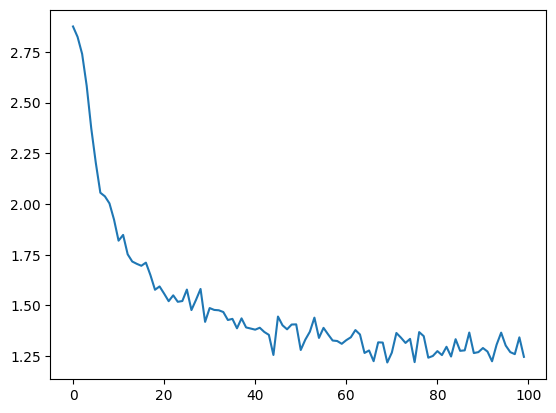

In [30]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

## Evaluating the Results

Let's see how well the model is doing on the training data. We can get a reasonable estimate with just part of the data, so we'll run 1000 samples through the network with `evaluate()`, which is the same as `train()` minus the backpropagation.




In [31]:
# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

total = 1000
correct = 0
# Go through a bunch of examples and record which are correctly guessed
for i in range(total):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    if category_i == guess_i:
        correct += 1
print("{}%".format(100 * correct / total))

53.9%


The score should be around 50-60%, which may seem low, but consider how tricky this task can be!




### Running on User Input

This function shows the output for a sample input you can provide.

In [32]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Kummerfeld')
predict('Kay')


> Kummerfeld
(-0.49) English
(-1.82) Polish
(-2.69) Greek

> Kay
(-1.26) Scottish
(-1.71) English
(-2.12) Irish


# Resources

For more on RNNs, see:

- [Chapter 9 of J+M](https://web.stanford.edu/~jurafsky/slp3/9.pdf)
- [Chapter 7, section 6 of E](https://github.com/jacobeisenstein/gt-nlp-class/blob/master/notes/eisenstein-nlp-notes.pdf)
-  [The Unreasonable Effectiveness of Recurrent Neural
   Networks](https://karpathy.github.io/2015/05/21/rnn-effectiveness/)_
   shows a bunch of real life examples
-  [Understanding LSTM
   Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)_
   is about LSTMs specifically but also informative about RNNs in
   general

# Task 2

Above, we trained and tested on the same data. That is misleading, because the model saw those examples during training.

In this task:
1. Modify the data reading process to split the data randomly into a test set (\~10% of the data) and train set (\~90% of the data). Train and test again.
2. Modify `randomTrainingExample` to sample from your training data. Implement a `randomTestExample` to sample from your test data.
3. Create a new instance of the model.
4. Train that instance with the training data you created.
5. Test it with the test data you created.

In [34]:
# Solution

import random

category_lines_train = {}
category_lines_test = {}

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    random.shuffle(lines)
    split_point = int(len(lines) * 0.1)
    category_lines_train[category] = lines[split_point:]
    category_lines_test[category] = lines[:split_point]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines_train[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor
    
def randomTestExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines_test[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor
    
new_rnn = RNN(n_letters, n_hidden, n_categories)

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []
start = time.time()
for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

        
total = 1000
correct = 0
# Go through a bunch of examples and record which are correctly guessed
for i in range(total):
    category, line, category_tensor, line_tensor = randomTestExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    if category_i == guess_i:
        correct += 1
print("{}%".format(100 * correct / total))

5000 5% (0m 6s) 2.4777 Jivilo / Italian ✗ (Russian)
10000 10% (0m 12s) 0.1989 Mcgregor / Scottish ✓
15000 15% (0m 18s) 0.1212 Davidson / Scottish ✓
20000 20% (0m 24s) 0.3510 Awad / Arabic ✓
25000 25% (0m 30s) 0.0289 Seok / Korean ✓
30000 30% (0m 37s) 0.8365 Ahearn / Irish ✓
35000 35% (0m 43s) 3.1502 Notaro / Japanese ✗ (Italian)
40000 40% (0m 49s) 0.0326 Karnoupakis / Greek ✓
45000 45% (0m 55s) 1.4151 Sandoval / Irish ✗ (Spanish)
50000 50% (1m 1s) 2.1369 Medina / Japanese ✗ (Spanish)
55000 55% (1m 8s) 0.8034 Souza / Portuguese ✓
60000 60% (1m 14s) 5.4947 Albuquerque / Portuguese ✗ (Spanish)
65000 65% (1m 20s) 2.0467 Crocker / Polish ✗ (English)
70000 70% (1m 26s) 0.1829 Cathan / Irish ✓
75000 75% (1m 32s) 0.1102 Jaskulski / Polish ✓
80000 80% (1m 39s) 1.7714 Espino / Italian ✗ (Spanish)
85000 85% (1m 45s) 0.2118 Romijnsen / Dutch ✓
90000 90% (1m 51s) 1.2395 Aller / Dutch ✓
95000 95% (1m 57s) 0.1145 Baldinotti / Italian ✓
100000 100% (2m 3s) 2.3663 Costa / Spanish ✗ (Portuguese)
46.4%


# Task 3

The model is entirely linear so far. Modify it to be the basic RNN introduced in lecture 4.

In the process, also change the weight initialisation to set them to be random values uniformly distributed in the range (-sqrt(k), sqrt(k)) where k is 1/hidden_size.

The cells below contains all the key code from above for easier manipulation.

In [35]:
# Data

from io import open
import glob
import os
import unicodedata
import string
import random
import time
import math

import torch
import torch.nn as nn

# Get files
def findFiles(path):
    return glob.glob(path)

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [36]:
# Solution

# Model and Inference

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        # Define the structure of the model
        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        
        self.softmax = nn.LogSoftmax(dim=1)
        
        self.init_weights()
        
    def init_weights(self):
        initrange = math.sqrt(1 / self.hidden_size)
        self.i2h.weight.data.uniform_(-initrange, initrange)
        self.i2h.bias.data.zero_()
        self.h2o.weight.data.uniform_(-initrange, initrange)
        self.h2o.bias.data.zero_()
        self.h2h.weight.data.uniform_(-initrange, initrange)
        self.h2h.bias.data.zero_()
        
    def initHidden(self):
        # Define the initial hidden state for an input as all zeros
        return torch.zeros(1, self.hidden_size)

    def forward(self, input_tensor, hidden):
        # Given an input, compute the steps defined by the model
        new_hidden = torch.tanh(self.i2h(input_tensor) + self.h2h(hidden))
        output = torch.tanh(self.h2o(new_hidden))
        output = self.softmax(output)
        return output, new_hidden

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [37]:
# Training

n_iters = 100000
print_every = 500 # note, we decreased this just to get more frequent updates, leaving it at 5000 is fine
plot_every = 1000

criterion = nn.NLLLoss()

learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

500 0% (0m 0s) 2.7957 Mcintyre / Scottish ✓
1000 1% (0m 1s) 2.8795 Totolos / Scottish ✗ (Greek)
1500 1% (0m 2s) 2.8675 Miyake / Scottish ✗ (Japanese)
2000 2% (0m 3s) 2.8303 Slusser / German ✓
2500 2% (0m 4s) 3.0446 Basara / Japanese ✗ (Arabic)
3000 3% (0m 5s) 2.4003 Rudawski / Polish ✓
3500 3% (0m 6s) 2.9387 Lieu / Spanish ✗ (Vietnamese)
4000 4% (0m 6s) 2.6066 Moon / Chinese ✗ (Korean)
4500 4% (0m 7s) 2.1325 Dubanowski / Polish ✓
5000 5% (0m 8s) 3.0999 Timpy / Arabic ✗ (Czech)
5500 5% (0m 9s) 2.5018 Traversa / Czech ✗ (Italian)
6000 6% (0m 10s) 2.4733 Travers / Dutch ✗ (French)
6500 6% (0m 11s) 2.4486 Cuocco / Portuguese ✗ (Italian)
7000 7% (0m 12s) 2.0431 Yong / Chinese ✓
7500 7% (0m 12s) 1.9658 Wan / Korean ✗ (Chinese)
8000 8% (0m 13s) 2.6405 Kolen / Arabic ✗ (Dutch)
8500 8% (0m 14s) 2.2362 Kouches / Greek ✓
9000 9% (0m 15s) 2.3719 Campbell / English ✓
9500 9% (0m 16s) 2.2705 Lecuyer / German ✗ (French)
10000 10% (0m 17s) 2.3217 Piontek / Czech ✗ (Polish)
10500 10% (0m 18s) 3.1668 Fu

In [38]:
# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

total = 1000
correct = 0
# Go through a bunch of examples and record which are correctly guessed
for i in range(total):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    if category_i == guess_i:
        correct += 1
print("{}%".format(100 * correct / total))

57.1%


In [39]:
import random

category_lines_train = {}
category_lines_test = {}

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    random.shuffle(lines)
    split_point = int(len(lines) * 0.1)
    category_lines_train[category] = lines[split_point:]
    category_lines_test[category] = lines[:split_point]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines_train[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor
    
def randomTestExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines_test[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor
    
new_rnn = RNN(n_letters, n_hidden, n_categories)

n_iters = 100000
print_every = 5000
plot_every = 1000

# Keep track of losses for plotting
current_loss = 0
all_losses = []
start = time.time()
for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

total = 1000
correct = 0
# Go through a bunch of examples and record which are correctly guessed
for i in range(total):
    category, line, category_tensor, line_tensor = randomTestExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    if category_i == guess_i:
        correct += 1
print("{}%".format(100 * correct / total))

5000 5% (0m 8s) 1.8619 Baroch / Irish ✗ (Czech)
10000 10% (0m 17s) 1.3567 Chavarria / Spanish ✓
15000 15% (0m 25s) 1.6375 Que / Chinese ✓
20000 20% (0m 34s) 1.5945 Ryoo / Korean ✓
25000 25% (0m 42s) 3.1197 Royer / German ✗ (French)
30000 30% (0m 51s) 1.6196 Rong / Chinese ✓
35000 35% (1m 0s) 1.5369 Halin / Russian ✓
40000 40% (1m 8s) 1.9003 Gilmour / French ✗ (English)
45000 45% (1m 17s) 1.5100 Reid / Scottish ✓
50000 50% (1m 25s) 1.3344 Cermak / Czech ✓
55000 55% (1m 34s) 1.4657 Colombo / Italian ✓
60000 60% (1m 43s) 1.4152 Hoang / Vietnamese ✓
65000 65% (1m 51s) 1.5286 Hang / Chinese ✓
70000 70% (2m 0s) 1.2001 Ferreira / Portuguese ✓
75000 75% (2m 8s) 1.2943 Raffel / Czech ✓
80000 80% (2m 17s) 1.3050 Lucassen / Dutch ✓
85000 85% (2m 26s) 1.6947 Wagner / Czech ✗ (German)
90000 90% (2m 34s) 1.4337 Hanek / Czech ✓
95000 95% (2m 43s) 1.5544 Maria / Spanish ✓
100000 100% (2m 51s) 1.2064 Kurmochi / Japanese ✓
51.3%
